In [1]:
import numpy as np
from numpy.random import randint
import matplotlib.pyplot as plt

from itertools import product as cartesian_product

from skimage.draw import circle, circle_perimeter

import matplotlib.animation as animation
from matplotlib import colors
from past.utils import old_div

import gym
from gym import spaces
from gym.utils import seeding

## Maze generators

#### Ref: https://github.com/rpinsler/gym-maze/blob/master/gym_maze/envs/generators.py

In [9]:
class MazeGenerator(object):
    def __init__(self):
        self.maze = None
    
    def sample_state(self):
        """Uniformaly sample an initial state and a goal state"""
        # Get indices for all free spaces, i.e. zero
        free_space = np.where(self.maze == 0)
        free_space = list(zip(free_space[0], free_space[1]))

        # Sample indices for initial state and goal state
        init_idx, goal_idx = np.random.choice(len(free_space), size=2, replace=False)
        
        # Convert initial state to a list, goal states to list of list
        init_state = list(free_space[init_idx])
        goal_states = [list(free_space[goal_idx])]  # TODO: multiple goals
        
        return init_state, goal_states
        
    def get_maze(self):
        return self.maze

In [10]:
class RandomMazeGenerator(MazeGenerator):
    def __init__(self, width=81, height=51, complexity=.75, density=.75):
        super().__init__()
        
        self.width = width
        self.height = height
        self.complexity = complexity
        self.density = density
        
        self.maze = self._generate_maze()
        
    def _generate_maze(self):
        """
        Code from https://en.wikipedia.org/wiki/Maze_generation_algorithm
        """
        # Only odd shapes
        shape = ((self.height // 2) * 2 + 1, (self.width // 2) * 2 + 1)
        # Adjust complexity and density relative to maze size
        self.complexity = int(self.complexity * (5 * (shape[0] + shape[1])))
        self.density    = int(self.density * ((shape[0] // 2) * (shape[1] // 2)))
        # Build actual maze
        Z = np.zeros(shape, dtype=bool)
        # Fill borders
        Z[0, :] = Z[-1, :] = 1
        Z[:, 0] = Z[:, -1] = 1
        # Make aisles
        for i in range(self.density):
            x, y = randint(0, shape[1]//2 + 1) * 2, randint(0, shape[0]//2 + 1) * 2
            Z[y, x] = 1
            for j in range(self.complexity):
                neighbours = []
                if x > 1:             neighbours.append((y, x - 2))
                if x < shape[1] - 2:  neighbours.append((y, x + 2))
                if y > 1:             neighbours.append((y - 2, x))
                if y < shape[0] - 2:  neighbours.append((y + 2, x))
                if len(neighbours):
                    y_,x_ = neighbours[randint(0, len(neighbours))]
                    if Z[y_, x_] == 0:
                        Z[y_, x_] = 1
                        Z[y_ + (y - y_) // 2, x_ + (x - x_) // 2] = 1
                        x, y = x_, y_
        return Z.astype(int)

(39, 39)

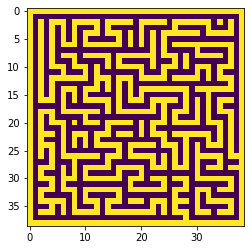

In [7]:
generator = RandomMazeGenerator(width=39, height=39)
plt.imshow(generator.get_maze())
generator.get_maze().shape

In [9]:
generator.sample_state() # init state and goal state

([25, 35], [[25, 32]])

## Environment

In [109]:
class MazeEnv(gym.Env):
    """Configurable environment for maze. """
    metadata = {'render.modes': ['human', 'rgb_array']}

    def __init__(self,
                 maze,
                 pob_size=1,
                 action_type='VonNeumann',
                 obs_type='full'):
        """Initialize the maze. DType: list"""
        
        self.EMPTY = 0
        self.WALL = 1
        self.AGENT = 2
        self.GOAL = 3
        
        # Random seed with internal gym seeding
        self.seed()

        # Maze: 0: free space, 1: wall
        self.maze = np.array(maze)
        self.maze_size = self.maze.shape
        
        x, y  = np.where(self.maze == self.AGENT)
        self.init_state = [x.item(), y.item()]
        self.maze[x, y] = 0
        
        x, y  = np.where(self.maze == self.GOAL)
        self.goal_states = [[x.item(), y.item()]]
        self.maze[x, y] = 0

        self.traces = []
        self.action_type = action_type
        self.obs_type = obs_type

        self.state = self.init_state

        # Action space: 0: Up, 1: Down, 2: Left, 3: Right
        if self.action_type == 'VonNeumann':  # Von Neumann neighborhood
            self.num_actions = 4
        elif action_type == 'Moore':  # Moore neighborhood
            self.num_actions = 8
        else:
            raise TypeError('Action type must be either \'VonNeumann\' or \'Moore\'')
        self.action_space = spaces.Discrete(self.num_actions)
        self.all_actions = list(range(self.action_space.n))

        # Size of the partial observable window
        self.pob_size = pob_size

        # Observation space
        low_obs = 0  # Lowest integer in observation
        high_obs = 3  # Highest integer in observation
        if self.obs_type == 'full':
            self.observation_space = spaces.Box(low=low_obs,
                                                high=high_obs,
                                                shape=self.maze_size, )
            # dtype=np.float32)
        elif self.obs_type == 'partial':
            self.observation_space = spaces.Box(low=low_obs,
                                                high=high_obs,
                                                shape=(self.pob_size * 2 + 1, self.pob_size * 2 + 1), )
            # dtype=np.float32)
        else:
            raise TypeError('Observation type must be either \'full\' or \'partial\'')


    def step(self, action):
        old_state = self.state
        # Update current state
        self.state = self._next_state(self.state, action)

        # Footprint: Record agent trajectory
        self.traces.append(self.state)

        if self._goal_test(self.state):  # Goal check
            reward = +1
            done = True
        elif self.state == old_state:  # Hit wall
            reward = -1
            done = False
        else:  # Moved, small negative reward to encourage shorest path
            reward = -0.01
            done = False

        # Additional info
        info = {}

        return self._get_obs(), reward, done, info

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)

        return [seed]

    def reset(self, maze = None):
        # Reset maze
        if maze is not None:
            self.maze = maze

        # Set current state be initial state
        self.state = self.init_state

        # Clean the traces of the trajectory
        self.traces = [self.init_state]

        return self._get_obs()

    def _goal_test(self, state):
        """Return True if current state is a goal state."""
        if type(self.goal_states[0]) == list:
            return list(state) in self.goal_states
        elif type(self.goal_states[0]) == tuple:
            return tuple(state) in self.goal_states

    def _next_state(self, state, action):
        """Return the next state from a given state by taking a given action."""

        # Transition table to define movement for each action
        if self.action_type == 'VonNeumann':
            transitions = {0: [-1, 0], 1: [+1, 0], 2: [0, -1], 3: [0, +1]}
        elif self.action_type == 'Moore':
            transitions = {0: [-1, 0], 1: [+1, 0], 2: [0, -1], 3: [0, +1],
                           4: [-1, +1], 5: [+1, +1], 6: [-1, -1], 7: [+1, -1]}

        new_state = [state[0] + transitions[action][0], state[1] + transitions[action][1]]
        if self.maze[new_state[0]][new_state[1]] == 1:  # Hit wall, stay there
            return state
        else:  # Valid move for 0, 2, 3, 4
            return new_state

    def _get_obs(self):
        if self.obs_type == 'full':
          #  return self._get_full_obs().flatten()
            return self._get_full_obs()
        elif self.obs_type == 'partial':
          #  return self._get_partial_obs(self.pob_size).flatten()
            return self._get_partial_obs(self.pob_size)

    def _get_full_obs(self):
        """Return a 2D array representation of maze."""
        obs = np.array(self.maze)
        # Set goal positions
        for goal in self.goal_states:
            obs[goal[0]][goal[1]] = 3  # 3: goal

        # Set current position
        # Come after painting goal positions, avoid invisible within multi-goal regions
        obs[self.state[0]][self.state[1]] = 2  # 2: agent

        return obs

    def _get_partial_obs(self, size=1):
        """Get partial observable window according to Moore neighborhood"""
        # Get maze with indicated location of current position and goal positions
        maze = self._get_full_obs()
        pos = np.array(self.state)

        under_offset = np.min(pos - size)
        over_offset = np.min(len(maze) - (pos + size + 1))
        offset = np.min([under_offset, over_offset])

        if offset < 0:  # Need padding
            maze = np.pad(maze, np.abs(offset), 'constant', constant_values=1)
            pos += np.abs(offset)

        return maze[pos[0] - size: pos[0] + size + 1, pos[1] - size: pos[1] + size + 1]

In [110]:
m = RandomMazeGenerator(width=8, height=8)
maze = m.get_maze()
maze[1][1] = 2
maze[-2][-2] = 3
maze

array([[1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 2, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 1, 1, 1, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 0, 1],
       [1, 0, 1, 1, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 0, 0, 1, 0, 1],
       [1, 0, 1, 1, 1, 1, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 3, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1]])

reward:  -1
reward:  -0.01
reward:  -0.01
reward:  -0.01


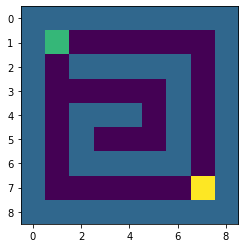

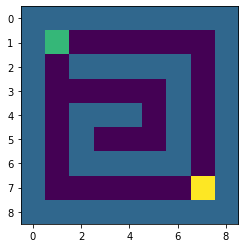

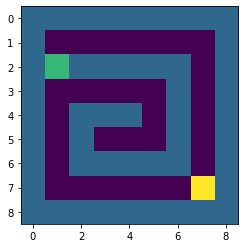

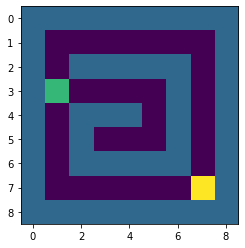

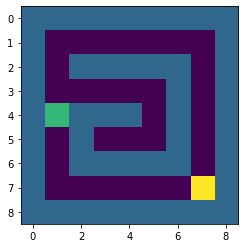

In [111]:
envir = MazeEnv(maze)
plt.imshow(envir._get_full_obs())

obs, reward, done, info = envir.step(0)
plt.figure()
plt.imshow(obs)
print('reward: ', reward)

obs, reward, done, info = envir.step(1)
plt.figure()
plt.imshow(obs)
print('reward: ', reward)

obs, reward, done, info = envir.step(1)
plt.figure()
plt.imshow(obs)
print('reward: ', reward)

obs, reward, done, info = envir.step(1)
plt.figure()
plt.imshow(obs)
print('reward: ', reward)

In [112]:
def run_one_episode(env):
    '''Given a gym environment (env) it computer one episode and return cumulative reward.
    Used to check if our gym environments work'''
    
    env.reset()
    sum_reward = 0
    
    steps = []
    frames = []

    done = False
    while not done:
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        steps.append(reward)
        sum_reward += reward
        
    return steps, sum_reward

In [113]:
steps, sum_reward = run_one_episode(envir)
sum_reward

-149.55

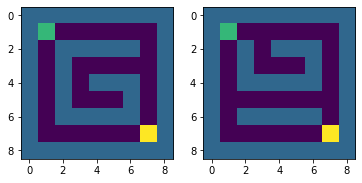

In [114]:
m = RandomMazeGenerator(width=8, height=8)
maze = m.get_maze()
maze[1][1] = 2
maze[-2][-2] = 3
maze0 = maze

m = RandomMazeGenerator(width=8, height=8)
maze = m.get_maze()
maze[1][1] = 2
maze[-2][-2] = 3
maze1 = maze

fig, axs = plt.subplots(1, 2)
axs[0].imshow(maze0)
axs[1].imshow(maze1)

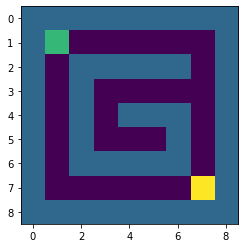

In [115]:
envir = MazeEnv(maze0)
plt.imshow(envir._get_full_obs())

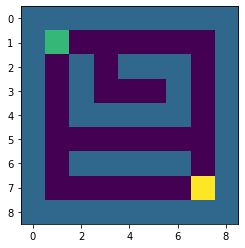

In [116]:
envir.reset(maze = maze1)
plt.imshow(envir._get_full_obs())

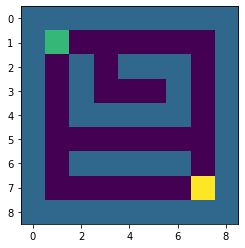

In [117]:
envir.reset()
plt.imshow(envir._get_full_obs())